In [105]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline  import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score,f1_score,confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import auc

In [106]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
pd.options.display.max_columns = None
pd.options.display.max_rows =999

In [108]:
flight_df = pd.read_csv("Combined_Flights_2021.csv")

In [109]:
flight_df.drop(columns=['OriginAirportSeqID', 'DOT_ID_Marketing_Airline','Flight_Number_Marketing_Airline','Tail_Number', 'OriginAirportID','OriginCityMarketID','DestAirportID','DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState','DestStateName','DepTimeBlk','ArrTimeBlk','FlightDate','OriginState','OriginStateName','OriginCityName', 'DOT_ID_Operating_Airline','Flight_Number_Operating_Airline'],inplace= True)   

In [110]:
flight_df.loc[flight_df['Cancelled'] == True, ['Cancelled', 'DepDelayMinutes']]

Cancelled  DepDelayMinutes
93            True              NaN
94            True              NaN
95            True              NaN
98            True              NaN
99            True              NaN
...            ...              ...
6310305       True              NaN
6310313       True              NaN
6310315       True              NaN
6310322       True            236.0
6310850       True              NaN

[111018 rows x 2 columns]

<Axes: title={'center': 'Flight Delay (Minutes)'}, ylabel='Frequency'>

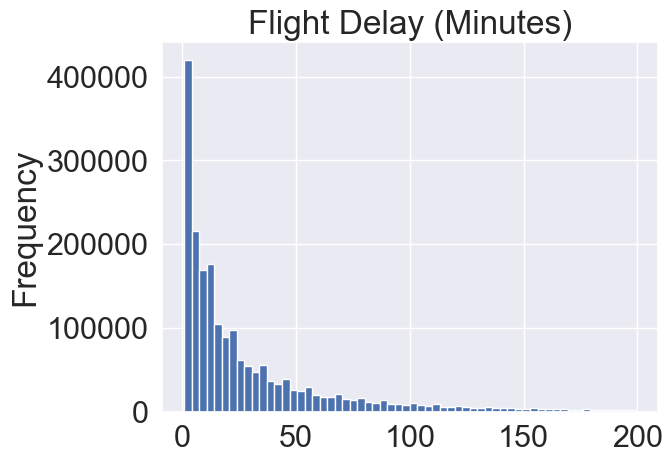

In [111]:
# Flight Delay - No of Flights Delayes as per DepDelayTRime

flight_df.query('(DepDelayMinutes > 0) and (DepDelayMinutes < 200)')['DepDelayMinutes'].plot(kind='hist', bins=60, title='Flight Delay (Minutes)')


In [112]:
# Adding a new column DelayGroup for forming Delay Groups as per the departure delay time
# 0 > OnTime_Early, 
# between 0 and 15 minutes > Small_Delay,
# between 15 and 45 minutes > Medium Delay,
# greater than 45 > Large_Delay
# If Cancelled = True, Delay Group > Cancelled

flight_df['DelayGroup'] = None
flight_df.loc[flight_df['DepDelayMinutes'] == 0, 'DelayGroup'] = 'OnTime_Early'
flight_df.loc[(flight_df['DepDelayMinutes'] > 0) & (flight_df['DepDelayMinutes'] <= 15), 'DelayGroup'] = 'Small_Delay'
flight_df.loc[(flight_df['DepDelayMinutes'] > 15) & (flight_df['DepDelayMinutes'] <= 45), 'DelayGroup'] = 'Medium_Delay'
flight_df.loc[flight_df['DepDelayMinutes'] > 45, 'DelayGroup'] = 'Large_Delay'
flight_df.loc[flight_df['Cancelled'], 'DelayGroup'] = 'Cancelled'

In [113]:
#% of Cancelled Flights

print(flight_df['Cancelled'].value_counts())
print('Percent Cancelled :', round(sum(flight_df['Cancelled'] == True) / len(flight_df['Cancelled']) * 100, 2), '% of all flights')

False    6200853
True      111018
Name: Cancelled, dtype: int64
Percent Cancelled : 1.76 % of all flights


In [114]:
#% of Diverted Flights
print(flight_df['Diverted'].value_counts())
print('Percent Diverted :', round(sum(flight_df['Diverted'] == True) / len(flight_df['Diverted']) * 100, 2), '% of all flights')

False    6296889
True       14982
Name: Diverted, dtype: int64
Percent Diverted : 0.24 % of all flights


In [115]:
#Delay Group count
flight_df['DelayGroup'].value_counts()

OnTime_Early    4146782
Small_Delay     1019071
Medium_Delay     562885
Large_Delay      472115
Cancelled        111018
Name: DelayGroup, dtype: int64

<Axes: xlabel='DelayGroup', ylabel='count'>

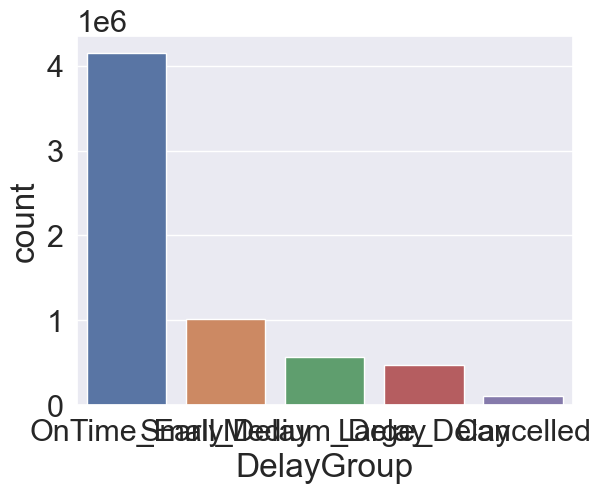

In [116]:
#Delaygroup Histogram
sns.countplot(data=flight_df, x='DelayGroup')

In [117]:
#Monthwise Delay categories

df_agg = flight_df.groupby('Month')['DelayGroup'].value_counts(normalize=True).unstack() * 100 # Grouping by month and unstacking the delay group
col_order = ['OnTime_Early','Small_Delay','Medium_Delay','Large_Delay','Cancelled'] # resorting the columns.
df_agg[col_order].style.background_gradient(cmap='Blues')

<Axes: xlabel='count', ylabel='Airline'>

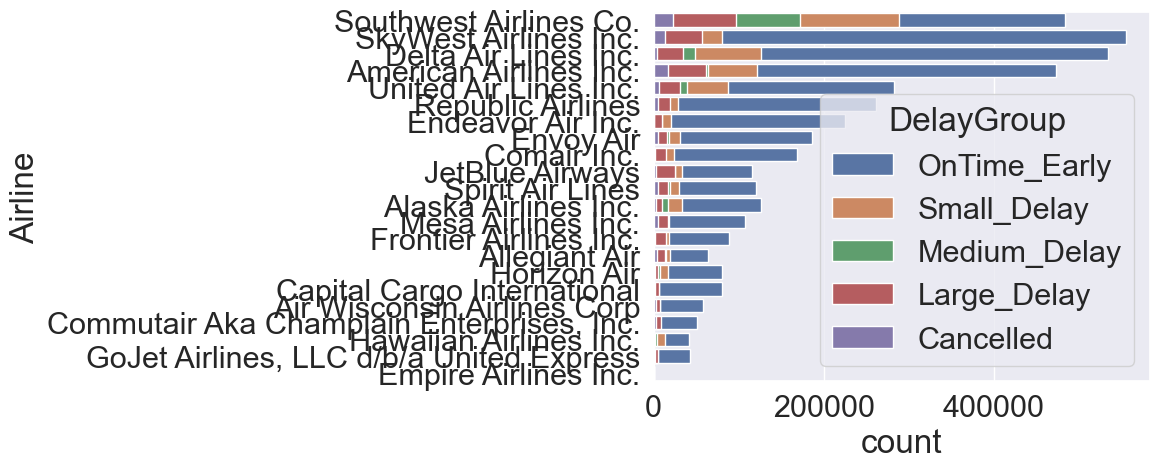

In [118]:
#Delay categories based on airlines
airline_order = flight_df['Airline'].value_counts().index.tolist()
sns.countplot(data=flight_df, y='Airline', order=airline_order, hue='DelayGroup', dodge=False)

In [119]:
#%of each delay group by airline
flight_df['Airline'] = flight_df['Airline'].astype('category')
flight_df_1 = flight_df.groupby('Airline')['DelayGroup'].value_counts().unstack()

total_flights = flight_df_1.sum(axis=1)
for c in flight_df_1.columns:
    flight_df_1[c] = flight_df_1[c] / total_flights

In [120]:
#Order by airline with the most flights
airlines_ordered = total_flights.sort_values(ascending=False).index

In [121]:
flight_df_1.loc[airlines_ordered].sort_values('OnTime_Early', ascending=False) \
    [['OnTime_Early','Small_Delay','Medium_Delay','Large_Delay']] \
    .style.background_gradient(axis=0, cmap='YlOrRd')

In [122]:
airline_counts= flight_df['Airline'].value_counts()
print(airline_counts)

Southwest Airlines Co.                       1064640
SkyWest Airlines Inc.                         753343
Delta Air Lines Inc.                          747998
American Airlines Inc.                        736399
United Air Lines Inc.                         446837
Republic Airlines                             332926
Endeavor Air Inc.                             266867
Envoy Air                                     255751
Comair Inc.                                   222602
JetBlue Airways                               202702
Spirit Air Lines                              191361
Alaska Airlines Inc.                          188955
Mesa Airlines Inc.                            159789
Frontier Airlines Inc.                        137142
Allegiant Air                                 115881
Horizon Air                                   111628
Capital Cargo International                    99331
Air Wisconsin Airlines Corp                    80256
Commutair Aka Champlain Enterprises, Inc.     

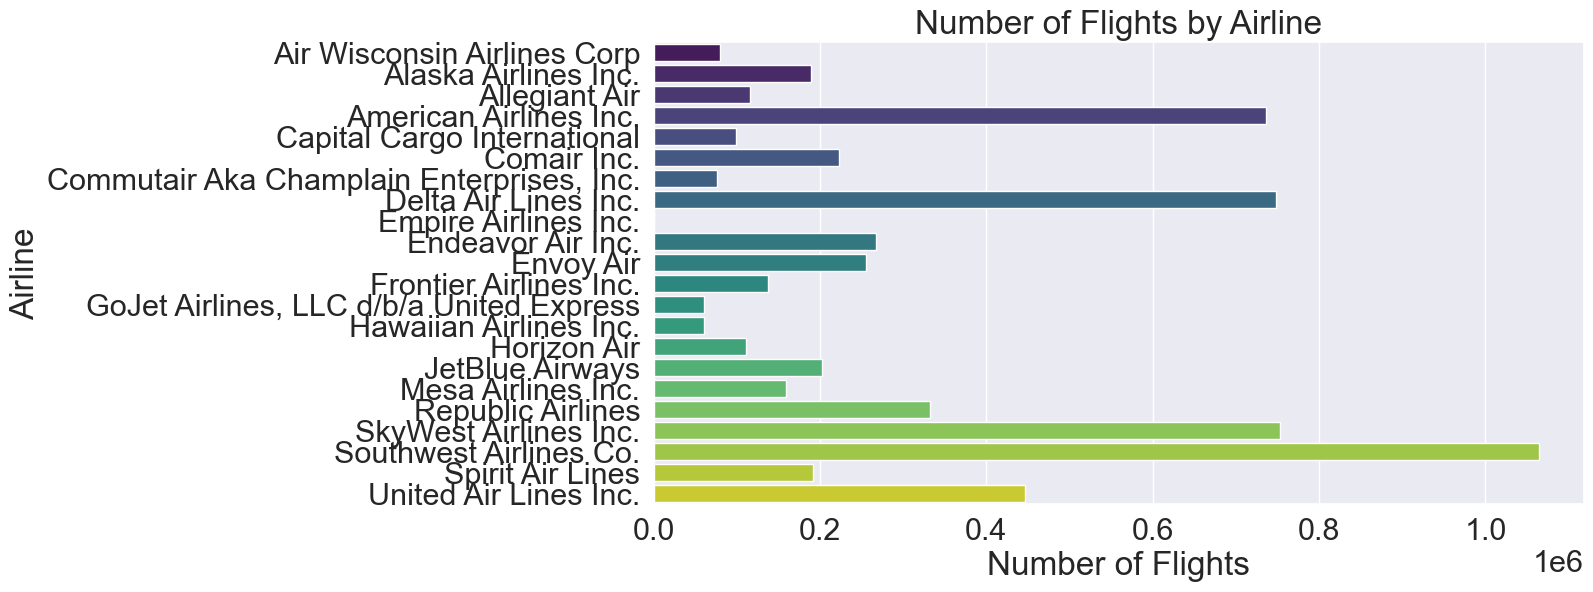

In [123]:
plt.figure(figsize=(12, 6))
sns.barplot(x=airline_counts.values, y=airline_counts.index, palette='viridis')
plt.title('Number of Flights by Airline')
plt.xlabel('Number of Flights')
plt.ylabel('Airline')
plt.show()

In [124]:
#Correlation Analysis - Matrix

corr_matrix = flight_df.corr()
corr_matrix

C:\Users\prerd\AppData\Local\Temp\ipykernel_44868\2608495923.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = flight_df.corr()


Cancelled  Diverted  CRSDepTime   DepTime  \
Cancelled              1.000000 -0.006527    0.015093  0.007487   
Diverted              -0.006527  1.000000    0.002691  0.004637   
CRSDepTime             0.015093  0.002691    1.000000  0.959910   
DepTime                0.007487  0.004637    0.959910  1.000000   
DepDelayMinutes        0.022039  0.017776    0.081076  0.111973   
DepDelay               0.022155  0.018422    0.085692  0.118499   
ArrTime                     NaN  0.005308    0.659313  0.680305   
ArrDelayMinutes             NaN       NaN    0.071785  0.101051   
AirTime                     NaN       NaN   -0.016883 -0.023927   
CRSElapsedTime        -0.009846  0.013850   -0.020463 -0.027048   
ActualElapsedTime           NaN       NaN   -0.019585 -0.025925   
Distance              -0.011034  0.012746   -0.010115 -0.018763   
Year                        NaN       NaN         NaN       NaN   
Quarter               -0.006519  0.001036    0.013838  0.017319   
Month                 -0.004586  0.001005    0.014257  0.017963   
DayofMonth             0.002586  0.000995   -0.000239  0.000001   
DayOfWeek             -0.003405 -0.001047    0.002753  0.003473   
OriginStateFips        0.010816  0.000619   -0.007123 -0.005714   
OriginWac              0.007977 -0.001084   -0.016077 -0.017588   
DestStateFips          0.010537  0.001154    0.011806  0.010095   
DestWac                0.008405  0.000056    0.014110  0.020761   
DepDel15               0.017339  0.019810    0.157153  0.208351   
DepartureDelayGroups   0.024937  0.022458    0.125327  0.186885   
TaxiOut                0.005838  0.012591    0.002063  0.006030   
WheelsOff              0.003741  0.004795    0.934223  0.972836   
WheelsOn                    NaN  0.006847    0.687838  0.709858   
TaxiIn                      NaN  0.019767   -0.036046 -0.035007   
CRSArrTime             0.010936  0.007910    0.744807  0.745001   
ArrDelay                    NaN       NaN    0.083025  0.115711   
ArrDel15                    NaN       NaN    0.130085  0.176590   
ArrivalDelayGroups          NaN       NaN    0.112118  0.169783   
DistanceGroup         -0.011177  0.012864   -0.012205 -0.020802   
DivAirportLandings     0.064676  0.467928    0.004065  0.005393   

                      DepDelayMinutes  DepDelay   ArrTime  ArrDelayMinutes  \
Cancelled                    0.022039  0.022155       NaN              NaN   
Diverted                     0.017776  0.018422  0.005308              NaN   
CRSDepTime                   0.081076  0.085692  0.659313         0.071785   
DepTime                      0.111973  0.118499  0.680305         0.101051   
DepDelayMinutes              1.000000  0.997354  0.018854         0.980574   
DepDelay                     0.997354  1.000000  0.023843         0.976491   
ArrTime                      0.018854  0.023843  1.000000         0.017048   
ArrDelayMinutes              0.980574  0.976491  0.017048         1.000000   
AirTime                      0.010023  0.015186  0.020667         0.014633   
CRSElapsedTime               0.012150  0.017007  0.017560         0.005999   
ActualElapsedTime            0.014279  0.018893  0.021697         0.036817   
Distance                     0.012497  0.018189  0.018938         0.007414   
Year                              NaN       NaN       NaN              NaN   
Quarter                      0.041851  0.050488 -0.010942         0.035285   
Month                        0.042345  0.051196 -0.010818         0.035671   
DayofMonth                   0.007115  0.008158 -0.003767         0.007293   
DayOfWeek                    0.007543  0.009830  0.000819         0.005528   
OriginStateFips              0.001887 -0.000332 -0.011631         0.004639   
OriginWac                    0.006997  0.011436  0.016951         0.004758   
DestStateFips                0.003815  0.000886  0.018731         0.006288   
DestWac                      0.002229  0.004844  0.011989         0.000027   
DepDel15                   

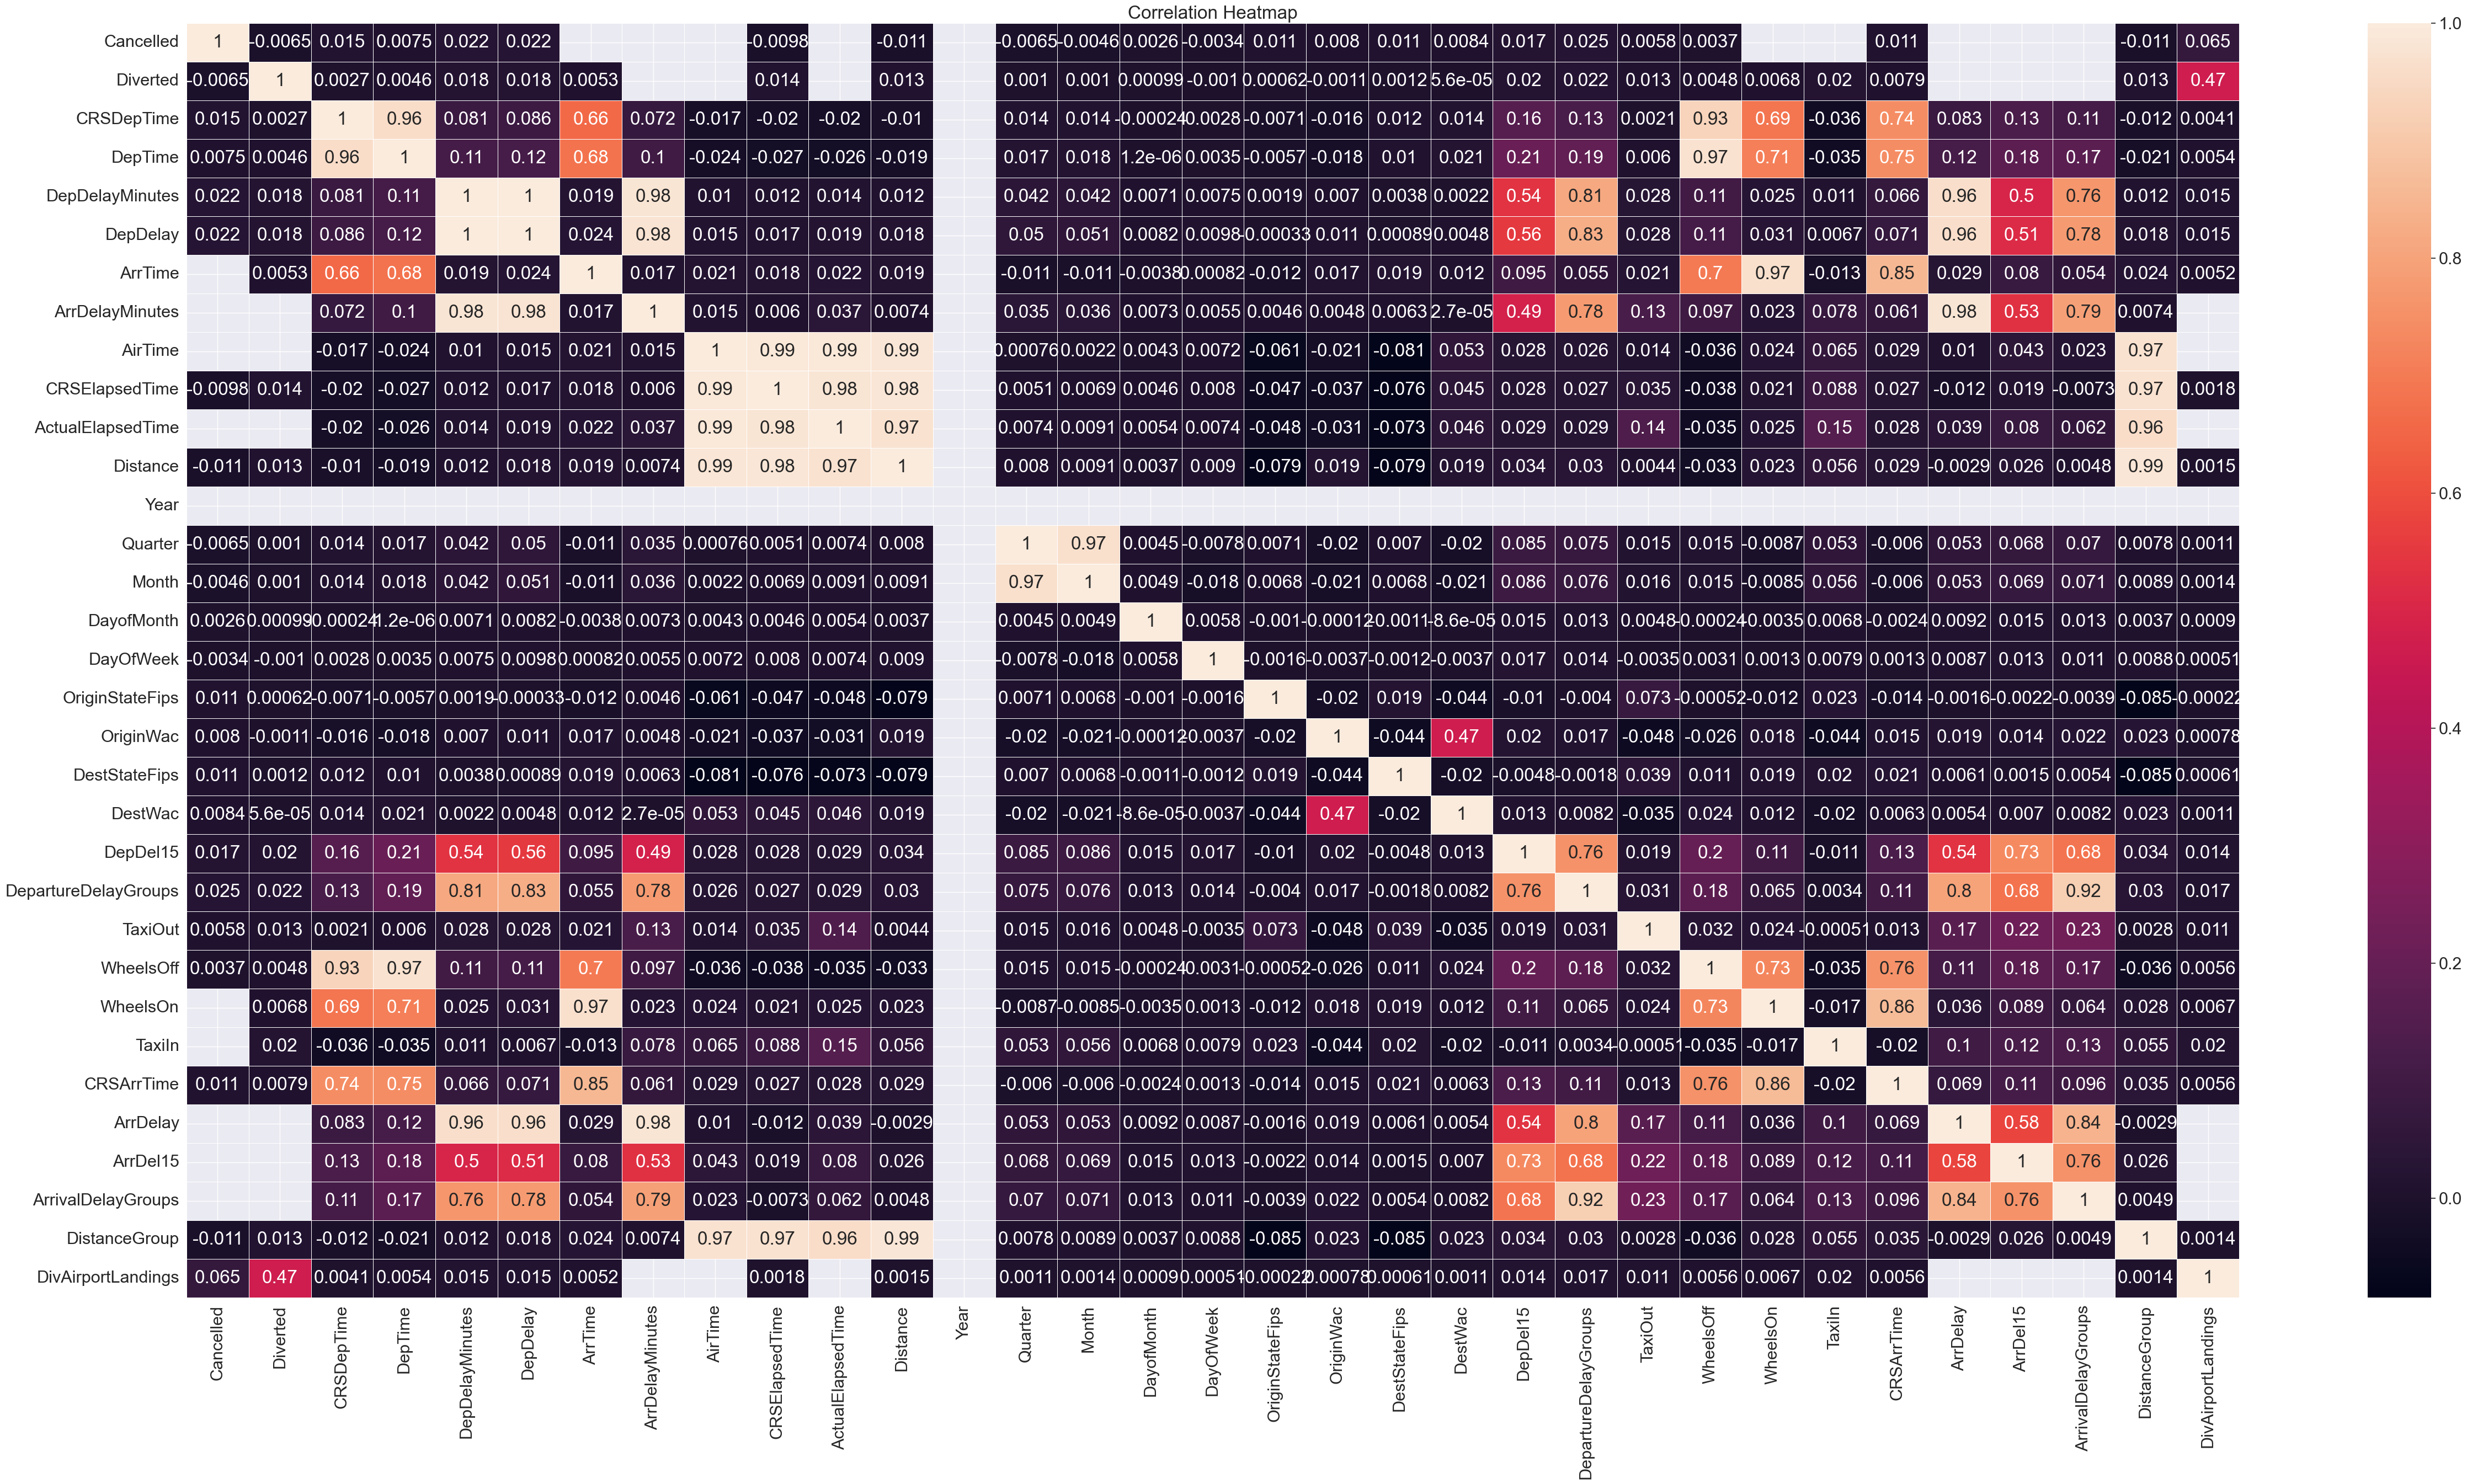

In [125]:
# Correlation Analysis - Heatmap

plt.figure(figsize=(60, 30))  # Increase the figure size
sns.set(font_scale=2)  # Adjust font size for annotations
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [126]:
# Average Departure Delay by Airline

avg_dep_delay_by_airline = flight_df.groupby('Airline')['DepDelayMinutes'].mean().sort_values(ascending=False)
avg_dep_delay_by_airline

Airline
Commutair Aka Champlain Enterprises, Inc.    21.680783
JetBlue Airways                              20.311685
Allegiant Air                                19.634153
Mesa Airlines Inc.                           18.057408
Air Wisconsin Airlines Corp                  16.553045
Frontier Airlines Inc.                       15.954884
GoJet Airlines, LLC d/b/a United Express     15.667626
Southwest Airlines Co.                       14.802173
American Airlines Inc.                       14.527001
Spirit Air Lines                             14.462256
SkyWest Airlines Inc.                        13.931217
United Air Lines Inc.                        12.196467
Comair Inc.                                  10.456981
Envoy Air                                     9.976197
Capital Cargo International                   9.970415
Republic Airlines                             9.454969
Delta Air Lines Inc.                          8.852645
Alaska Airlines Inc.                          8.575051
Ho

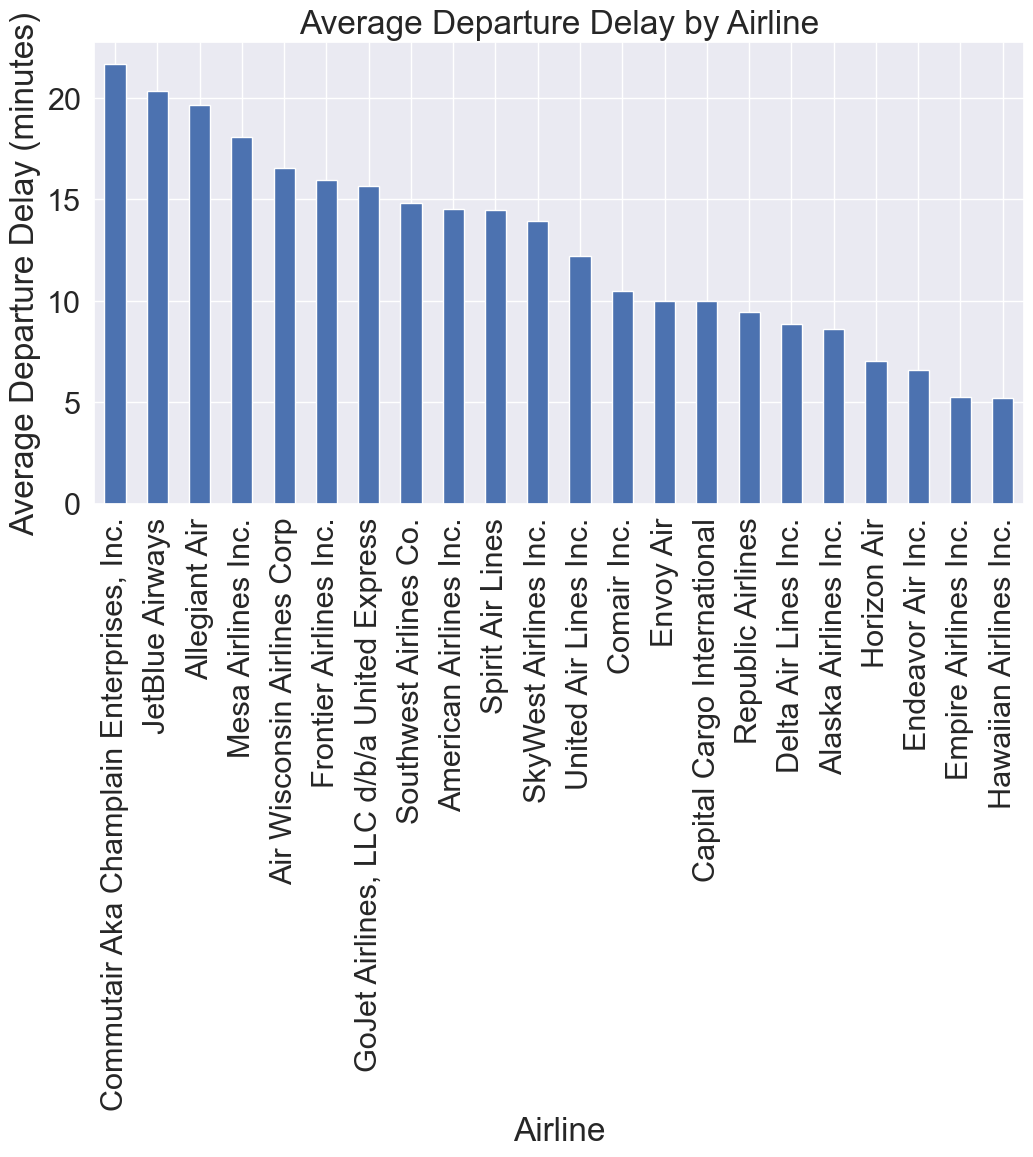

In [127]:
# Average Departure Delay by Airline - Visualization

avg_dep_delay_by_airline.plot(kind='bar', figsize=(12, 6))
plt.title('Average Departure Delay by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Departure Delay (minutes)')
plt.show()

In [128]:
# Average Arrival Delay by Airline

avg_arr_delay_by_airline = flight_df.groupby('Airline')['ArrDelayMinutes'].mean().sort_values(ascending=False)
avg_arr_delay_by_airline

Airline
Commutair Aka Champlain Enterprises, Inc.    23.407156
Allegiant Air                                21.274423
JetBlue Airways                              19.945458
Mesa Airlines Inc.                           18.249950
Air Wisconsin Airlines Corp                  17.327440
GoJet Airlines, LLC d/b/a United Express     16.756907
Frontier Airlines Inc.                       16.033348
Spirit Air Lines                             14.593450
SkyWest Airlines Inc.                        14.253187
American Airlines Inc.                       13.793588
Southwest Airlines Co.                       12.613220
United Air Lines Inc.                        12.238722
Comair Inc.                                  10.883368
Envoy Air                                    10.835396
Capital Cargo International                  10.777159
Republic Airlines                            10.325604
Alaska Airlines Inc.                          9.507075
Delta Air Lines Inc.                          8.509149
Ho

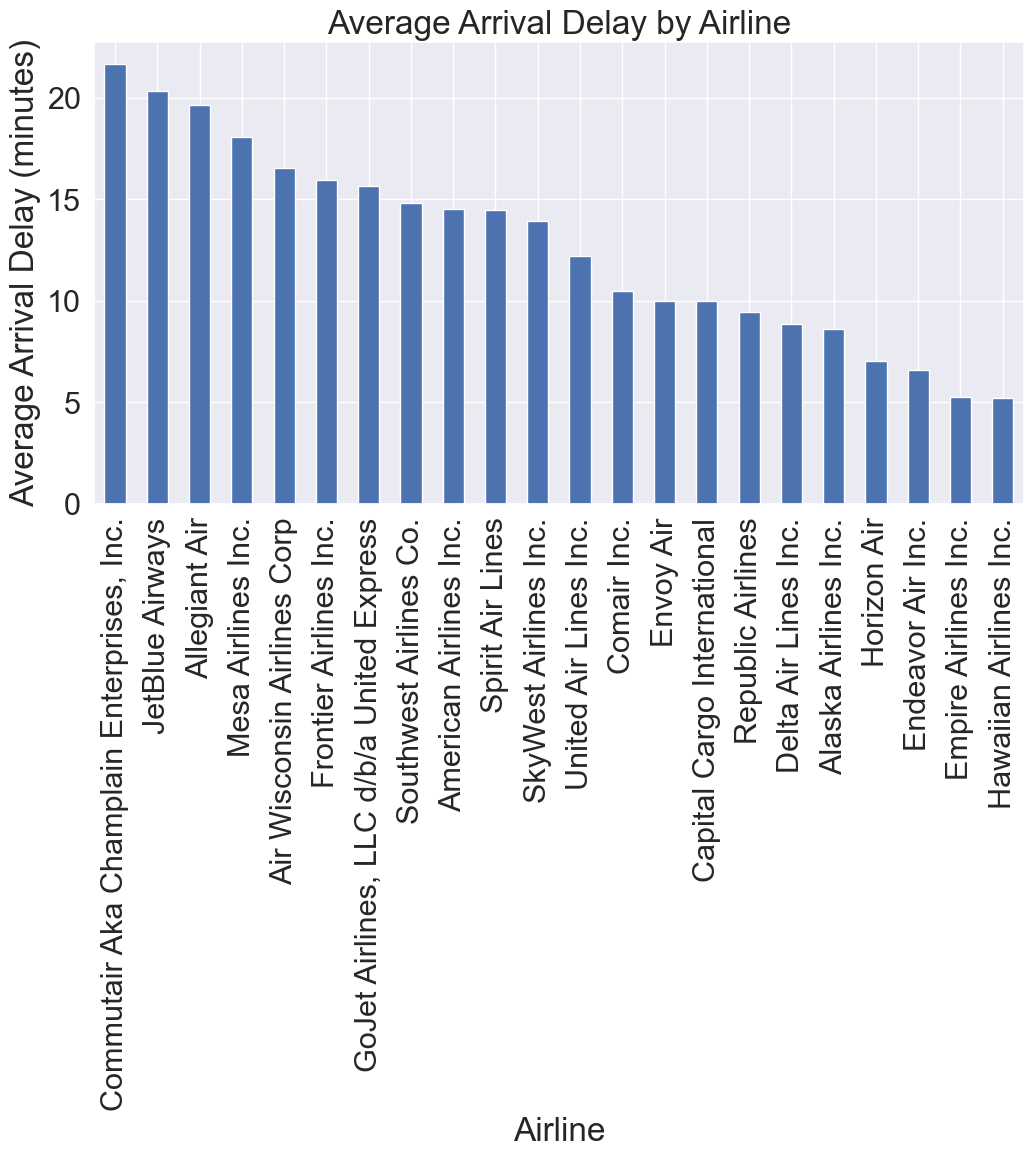

In [129]:
# Average Arrival Delay by Airline - Visualization

avg_dep_delay_by_airline.plot(kind='bar', figsize=(12, 6))
plt.title('Average Arrival Delay by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Arrival Delay (minutes)')
plt.show()

In [130]:
import numpy as np
flight_df['Month_Sin'] = np.sin(2 * np.pi * flight_df['Month'] / 12)
flight_df['Month_Cos'] = np.cos(2 * np.pi * flight_df['Month'] / 12)
flight_df['DayOfWeek_Sin'] = np.sin(2 * np.pi * flight_df['DayOfWeek'] / 7)
flight_df['DayOfWeek_Cos'] = np.cos(2 * np.pi * flight_df['DayOfWeek'] / 7)

In [131]:
year_mean_distance = flight_df.groupby('Year')['Distance'].mean()
quarter_mean_distance = flight_df.groupby('Quarter')['Distance'].mean()
day_mean_distance = flight_df.groupby('DayofMonth')['Distance'].mean()
flight_df = flight_df.merge(year_mean_distance, on='Year', suffixes=('', '_YearMean'))
flight_df = flight_df.merge(quarter_mean_distance, on='Quarter', suffixes=('', '_QuarterMean'))
flight_df = flight_df.merge(day_mean_distance, on='DayofMonth', suffixes=('', '_DayMean'))

In [132]:
flight_df.isna().sum()

Airline                                         0
Origin                                          0
Dest                                            0
Cancelled                                       0
Diverted                                        0
CRSDepTime                                      0
DepTime                                    108325
DepDelayMinutes                            108413
DepDelay                                   108413
ArrTime                                    112408
ArrDelayMinutes                            126001
AirTime                                    126001
CRSElapsedTime                                  1
ActualElapsedTime                          126001
Distance                                        0
Year                                            0
Quarter                                         0
Month                                           0
DayofMonth                                      0
DayOfWeek                                       0


In [133]:
flight_df.dropna(axis=1, inplace = True)

In [134]:
flight_df.columns

Index(['Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted', 'CRSDepTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'IATA_Code_Marketing_Airline', 'Operating_Airline',
       'IATA_Code_Operating_Airline', 'OriginStateFips', 'OriginWac',
       'DestStateFips', 'DestWac', 'CRSArrTime', 'DistanceGroup', 'DelayGroup',
       'Month_Sin', 'Month_Cos', 'DayOfWeek_Sin', 'DayOfWeek_Cos',
       'Distance_YearMean', 'Distance_QuarterMean', 'Distance_DayMean'],
      dtype='object')

In [135]:
flight_df.drop(columns=['DelayGroup'])

Airline Origin Dest  Cancelled  Diverted  CRSDepTime  \
0        SkyWest Airlines Inc.    SGU  PHX      False     False         724   
1        SkyWest Airlines Inc.    PHX  SGU      False     False         922   
2        SkyWest Airlines Inc.    MHT  ORD      False     False        1330   
3        SkyWest Airlines Inc.    DFW  TRI      False     False        1645   
4        SkyWest Airlines Inc.    PHX  BFL      False     False        1844   
...                        ...    ...  ...        ...       ...         ...   
6311866            Comair Inc.    CHO  CLT      False     False        1246   
6311867            Comair Inc.    CLT  CHO      False     False        1059   
6311868            Comair Inc.    MHT  CLT      False     False         600   
6311869            Comair Inc.    CLT  RIC      False     False        1325   
6311870            Comair Inc.    RIC  CLT      False     False        1525   

         Distance  Year  Quarter  Month  DayofMonth  DayOfWeek  \
0           262.0  2021        1      3           3          3   
1           262.0  2021        1      3           3          3   
2           843.0  2021        1      3           3          3   
3           868.0  2021        1      3           3          3   
4           425.0  2021        1      3           3          3   
...           ...   ...      ...    ...         ...        ...   
6311866     245.0  2021        3      7          11          7   
6311867     245.0  2021        3      7          11          7   
6311868     737.0  2021        3      7          11          7   
6311869     257.0  2021        3      7          11          7   
6311870     257.0  2021        3      7          11          7   

        Marketing_Airline_Network Operated_or_Branded_Code_Share_Partners  \
0                              AA                            AA_CODESHARE   
1                              AA                            AA_CODESHARE   
2                              AA                            AA_CODESHARE   
3                              AA                            AA_CODESHARE   
4                              AA                            AA_CODESHARE   
...                           ...                                     ...   
6311866                        AA                            AA_CODESHARE   
6311867                        AA                            AA_CODESHARE   
6311868                        AA                            AA_CODESHARE   
6311869                        AA                            AA_CODESHARE   
6311870                        AA                            AA_CODESHARE   

        IATA_Code_Marketing_Airline Operating_Airline  \
0                                AA                OO   
1                                AA                OO   
2                                AA                OO   
3                                AA                OO   
4                                AA                OO   
...                             ...               ...   
6311866                          AA                OH   
6311867                          AA                OH   
6311868                          AA                OH   
6311869                          AA                OH   
6311870                          AA                OH   

        IATA_Code_Operating_Airline  OriginStateFips  OriginWac  \
0                                OO               49         87   
1                                OO                4         81   
2                                OO               33         14   
3                                OO               48         74   
4                                OO                4         81   
...                             ...              ...        ...   
6311866                          OH               51         38   
6311867                          OH               37         36   
6311868                          OH               33         14   
6

In [73]:
y = flight_df['Cancelled'].values

In [74]:
X = flight_df.drop(columns=['Diverted','Cancelled'],inplace = True)
X = flight_df.values


In [75]:
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size= 0.3, stratify=y, random_state=1)


In [76]:
idx = np.random.choice(np.arange(len(X_test)), 20000, replace=False)
X_test = X_test[idx]
y_test = y_test[idx]

In [77]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
rus = RandomUnderSampler(random_state=1)
ros = RandomOverSampler(random_state=1)
# X_rus, y_rus = rus.fit_resample(X_train, y_train)
X_rus, y_rus = ros.fit_resample(X_train, y_train)
idx = np.random.choice(np.arange(len(X_rus)), 400000, replace=False)
X_rus = X_rus[idx]
y_rus = y_rus[idx]
np.bincount(y_rus)

array([200639, 199361], dtype=int64)

In [78]:
flight_df = pd.DataFrame(X_rus)
dftest = pd.DataFrame(X_test)

In [79]:
prefixes = ['Airline', 'Origin', 'Dest','Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'IATA_Code_Marketing_Airline', 'Operating_Airline',
       'IATA_Code_Operating_Airline']
flight_df = pd.get_dummies(flight_df, columns=[0,1,2,12,13,14,15,16], prefix=prefixes)
dftest = pd.get_dummies(dftest, columns=[0,1,2,12,13,14,15,16], prefix=prefixes)

C:\Users\prerd\AppData\Local\Temp\ipykernel_44868\3312976934.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  flight_df = pd.get_dummies(flight_df, columns=[0,1,2,12,13,14,15,16], prefix=prefixes)
C:\Users\prerd\AppData\Local\Temp\ipykernel_44868\3312976934.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  flight_df = pd.get_dummies(flight_df, columns=[0,1,2,12,13,14,15,16], prefix=prefixes)
C:\Users\prerd\AppData\Local\Temp\ipykernel_44868\3312976934.py:5: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dftest = pd.get_dummies(dftest, columns=[0,1,2,12,13,14,15,16], prefix=prefixes)
C:\Users\prerd\AppData\Local\Temp\ipykernel_44868\3312976934.py:5: FutureWarning: In a f

In [80]:
dftest

3       4     5  6   7   8  9  10            11  17  18    19 20  \
0       830   613.0  2021  2   6  25  5  AA  AA_CODESHARE   1  51   926  3   
1      1400   235.0  2021  1   2   7  7  UA  UA_CODESHARE  26  43  1625  1   
2      1800  1558.0  2021  3   7  25  7  UA            UA  42  23  2334  7   
3       645   728.0  2021  4  12   5  7  AA            AA  37  36   926  3   
4      1410  1979.0  2021  1   2   3  3  NK            NK  26  43  2126  8   
...     ...     ...   ... ..  ..  .. ..  ..           ...  ..  ..   ... ..   
19995   730   280.0  2021  1   2  24  3  AA  AA_CODESHARE  25  13   858  2   
19996  1425   821.0  2021  3   7   5  1  AA            AA  55  45  1644  4   
19997  1640   295.0  2021  3   8   5  4  AA  AA_CODESHARE  22  72  1802  2   
19998  1001   616.0  2021  1   3  10  3  UA  UA_CODESHARE   5  71  1253  3   
19999  1410   689.0  2021  2   5  15  6  DL            DL  13  34  1709  3   

             21        22        23        24          25          26  \
0           0.0      -1.0 -0.974928 -0.222521  795.576188  796.357721   
1      0.866025       0.5      -0.0       1.0  795.576188  782.661798   
2          -0.5 -0.866025      -0.0       1.0  795.576188  802.246377   
3          -0.0       1.0      -0.0       1.0  795.576188  796.863284   
4      0.866025       0.5  0.433884 -0.900969  795.576188  782.661798   
...         ...       ...       ...       ...         ...         ...   
19995  0.866025       0.5  0.433884 -0.900969  795.576188  782.661798   
19996      -0.5 -0.866025  0.781831   0.62349  795.576188  802.246377   
19997 -0.866025      -0.5 -0.433884 -0.900969  795.576188  802.246377   
19998       1.0       0.0  0.433884 -0.900969  795.576188  782.661798   
19999       0.5 -0.866025 -0.781831   0.62349  795.576188  796.357721   

               27  Airline_Air Wisconsin Airlines Corp  \
0      799.648806                                    0   
1      793.011332                                    0   
2      799.648806                                    0   
3      793.542658                                    0   
4      795.114401                                    0   
...           ...                                  ...   
19995  799.835776                                    0   
19996  793.542658                                    0   
19997  793.542658                                    0   
19998  792.977699                                    0   
19999  789.924661                                    0   

       Airline_Alaska Airlines Inc.  Airline_Allegiant Air  \
0                                 0                      0   
1                                 0                      0   
2                                 0                      0   
3                                 0                      0   
4                                 0                      0   
...                             ...                    ...   
19995                             0                      0   
19996                             0                      0   
19997                             0                      0   
19998                             0                      0   
19999                             0                      0   

       Airline_American Airlines Inc.  Airline_Capital Cargo International  \
0                                   0                                    0   
1                                   0                                    0   
2                                   0                                    0   
3                                   1                                    0   
4                                   0                                    0   
...                               ...                                  ...   
19995                               0                                    0   
19996                               1                                    0   
19997                               0               

In [81]:
flight_df

3       4     5  6   7   8  9  10            11  17  18    19  20  \
0        909  1046.0  2021  4  12  24  5  B6            B6  72   3  1244   5   
1        830  2342.0  2021  4  12   9  4  AA            AA   6  91  1114  10   
2       1820  2125.0  2021  4  10  31  7  AA            AA   6  91  2028   9   
3        607   731.0  2021  1   2  17  3  AA            AA  48  74   745   3   
4        725  1020.0  2021  3   7   2  5  WN            WN  48  74  1200   5   
...      ...     ...   ... ..  ..  .. ..  ..           ...  ..  ..   ...  ..   
399995  1955   602.0  2021  2   6  15  2  WN            WN   8  82  2055   3   
399996  1620  1048.0  2021  3   9  12  7  G4            G4  38  66  2059   5   
399997  1345   727.0  2021  3   7   6  2  WN            WN  12  33  1550   3   
399998  1150   196.0  2021  2   6  10  4  UA  UA_CODESHARE  17  41  1301   1   
399999   858   520.0  2021  1   2   2  2  AA  AA_CODESHARE  42  23  1056   3   

              21        22        23        24          25          26  \
0           -0.0       1.0 -0.974928 -0.222521  795.576188  796.863284   
1           -0.0       1.0 -0.433884 -0.900969  795.576188  796.863284   
2      -0.866025       0.5      -0.0       1.0  795.576188  796.863284   
3       0.866025       0.5  0.433884 -0.900969  795.576188  782.661798   
4           -0.5 -0.866025 -0.974928 -0.222521  795.576188  802.246377   
...          ...       ...       ...       ...         ...         ...   
399995       0.0      -1.0  0.974928 -0.222521  795.576188  796.357721   
399996      -1.0      -0.0      -0.0       1.0  795.576188  802.246377   
399997      -0.5 -0.866025  0.974928 -0.222521  795.576188  802.246377   
399998       0.0      -1.0 -0.433884 -0.900969  795.576188  796.357721   
399999  0.866025       0.5  0.974928 -0.222521  795.576188  782.661798   

                27  Airline_Air Wisconsin Airlines Corp  \
0       799.835776                                    0   
1       791.453429                                    0   
2       805.984585                                    0   
3       795.700698                                    0   
4       793.297552                                    0   
...            ...                                  ...   
399995  789.924661                                    0   
399996  791.875923                                    0   
399997  797.522954                                    0   
399998  792.977699                                    1   
399999  793.297552                                    0   

        Airline_Alaska Airlines Inc.  Airline_Allegiant Air  \
0                                  0                      0   
1                                  0                      0   
2                                  0                      0   
3                                  0                      0   
4                                  0                      0   
...                              ...                    ...   
399995                             0                      0   
399996                             0                      1   
399997                             0                      0   
399998                             0                      0   
399999                             0                      0   

        Airline_American Airlines Inc.  Airline_Capital Cargo International  \
0                                    0                                    0   
1                                    1                                    0   
2                                    1                                    0   
3                                    1                                    0   
4                                    0                                    0   
...                                ...                                  ...   
399995                               0                                    0   
399996                               0                         

In [82]:
common_columns = flight_df.columns.intersection(dftest.columns)
dftest = dftest.loc[:,common_columns]
missing_cols = set( flight_df.columns ) - set( dftest.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    dftest[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
dftest = dftest[flight_df.columns]

In [83]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
for i in range(27):
    if flight_df.iloc[:,i].dtype == 'O':
        flight_df.iloc[:,i] = ord_enc.fit_transform(flight_df.iloc[:,i].values.reshape(-1,1)) 
        dftest.iloc[:,i] = ord_enc.transform(dftest.iloc[:,i].values.reshape(-1,1)) 

C:\Users\prerd\AppData\Local\Temp\ipykernel_44868\4117085813.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  flight_df.iloc[:,i] = ord_enc.fit_transform(flight_df.iloc[:,i].values.reshape(-1,1))
C:\Users\prerd\AppData\Local\Temp\ipykernel_44868\4117085813.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dftest.iloc[:,i] = ord_enc.transform(dftest.iloc[:,i].values.reshape(-1,1))
C:\Users\prerd\AppData\Local\Temp\ipykernel_44868\4117085813.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the 

In [84]:
dftest

3       4    5    6     7     8    9   10    11    17    18  \
0      325.0   485.0  0.0  1.0   5.0  24.0  4.0  0.0   1.0   0.0  27.0   
1      655.0   133.0  0.0  0.0   1.0   6.0  6.0  8.0  13.0  21.0  24.0   
2      895.0  1214.0  0.0  2.0   6.0  24.0  6.0  8.0  12.0  37.0  13.0   
3      220.0   587.0  0.0  3.0  11.0   4.0  6.0  0.0   0.0  32.0  18.0   
4      665.0  1370.0  0.0  0.0   1.0   2.0  2.0  7.0  11.0  21.0  24.0   
...      ...     ...  ...  ...   ...   ...  ...  ...   ...   ...   ...   
19995  265.0   172.0  0.0  0.0   1.0  23.0  2.0  0.0   1.0  20.0   7.0   
19996  680.0   676.0  0.0  2.0   6.0   4.0  0.0  0.0   0.0  48.0  26.0   
19997  815.0   186.0  0.0  2.0   7.0   4.0  3.0  0.0   1.0  17.0  39.0   
19998  416.0   487.0  0.0  0.0   2.0   9.0  2.0  8.0  13.0   3.0  38.0   
19999  665.0   555.0  0.0  1.0   4.0  14.0  5.0  3.0   5.0   9.0  16.0   

           19   20    21    22   23   24   25   26    27  \
0       464.0  2.0   6.0   0.0  0.0  2.0  0.0  1.0  26.0   
1       883.0  0.0   8.0   7.0  3.0  6.0  0.0  0.0   7.0   
2      1312.0  6.0   4.0   1.0  3.0  6.0  0.0  3.0  26.0   
3       464.0  2.0   5.0  10.0  3.0  6.0  0.0  2.0   9.0   
4      1184.0  7.0   8.0   7.0  4.0  1.0  0.0  0.0  14.0   
...       ...  ...   ...   ...  ...  ...  ...  ...   ...   
19995   436.0  1.0   8.0   7.0  4.0  1.0  0.0  0.0  27.0   
19996   902.0  3.0   4.0   1.0  5.0  5.0  0.0  3.0   9.0   
19997   980.0  1.0   2.0   3.0  2.0  0.0  0.0  3.0   9.0   
19998   671.0  2.0  10.0   6.0  4.0  1.0  0.0  0.0   6.0   
19999   927.0  2.0   7.0   2.0  1.0  4.0  0.0  1.0   1.0   

       Airline_Air Wisconsin Airlines Corp  Airline_Alaska Airlines Inc.  \
0                                        0                             0   
1                                        0                             0   
2                                        0                             0   
3                                        0                             0   
4                                        0                             0   
...                                    ...                           ...   
19995                                    0                             0   
19996                                    0                             0   
19997                                    0                             0   
19998                                    0                             0   
19999                                    0                             0   

       Airline_Allegiant Air  Airline_American Airlines Inc.  \
0                          0                               0   
1                          0                               0   
2                          0                               0   
3                          0                               1   
4                          0                               0   
...                      ...                             ...   
19995                      0                               0   
19996                      0                               1   
19997                      0                               0   
19998                      0                               0   
19999                      0                               0   

       Airline_Capital Cargo International  Airline_Comair Inc.  \
0                                        0                    1   
1                                        0                    0   
2                                        0                    0   
3                                        0                    0   
4                                        0                    0   
...                                    ...                  ...   
19995                                    0                    0   
19996                                    0                    0   
19997                                    0                    0   
19998                                    0       

In [85]:
X_train = flight_df.values
X_test = dftest.values

In [86]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [87]:
print(np.bincount(y_rus))
print(np.bincount(y_test))

[200639 199361]
[19662   338]


In [88]:
# X_train > X_train_sc
# X_test > X_test_sc
# y_train > y_rus
# y_test > y_test

In [89]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(X_train_sc , y_rus)
y_train_pred = log_model.predict(X_train_sc)
y_test_pred = log_model.predict(X_test_sc)

In [90]:
#R-squared of train and test model

print('R-squared for training set: ', log_model.score(X_train_sc,y_rus))
print('R-squared for test set: ', log_model.score(X_test_sc,y_test))

R-squared for training set:  0.65194
R-squared for test set:  0.6298


In [91]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

my_matrix = confusion_matrix(y_test, y_test_pred)
print(my_matrix)
print('Accuracy: ', accuracy_score(y_test, y_test_pred))
print('Precision: ', precision_score(y_test, y_test_pred))
print('F1 score: ', f1_score(y_test, y_test_pred))

[[12363  7299]
 [  105   233]]
Accuracy:  0.6298
Precision:  0.03093467870419543
F1 score:  0.05921219822109275


In [92]:
#Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
opt_tree = DecisionTreeClassifier(random_state = 0)
opt_tree.fit(X_train_sc, y_rus)

DecisionTreeClassifier(random_state=0)

In [93]:
y_test_pred = opt_tree.predict(X_test_sc)

In [94]:
#Training score - Rsquared
print('Training score: ', opt_tree.score(X_train_sc, y_rus))
#Test accuracy score - Rsquared
print('Test score: ', opt_tree.score(X_test_sc,y_test))

Training score:  0.9999975
Test score:  0.8765


In [95]:
my_matrix = confusion_matrix(y_test, y_test_pred)
print(my_matrix)
print('Accuracy: ', accuracy_score(y_test, y_test_pred))
print('Precision: ', precision_score(y_test, y_test_pred))
print('F1 score: ', f1_score(y_test, y_test_pred))

[[17287  2375]
 [   95   243]]
Accuracy:  0.8765
Precision:  0.09281894576012223
F1 score:  0.16441136671177264


In [96]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train_sc, y_rus)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [97]:
y_test_pred = classifier.predict(X_test_sc)

In [98]:
#Training score - Rsquared
print('Training score: ', classifier.score(X_train_sc, y_rus))
#Test accuracy score - Rsquared
print('Test score: ', classifier.score(X_test_sc,y_test))

Training score:  0.998055
Test score:  0.91525


In [99]:
my_matrix = confusion_matrix(y_test, y_test_pred)
print(my_matrix)
print('Accuracy: ', accuracy_score(y_test, y_test_pred))
print('Precision: ', precision_score(y_test, y_test_pred))
print('F1 score: ', f1_score(y_test, y_test_pred))

[[18072  1590]
 [  105   233]]
Accuracy:  0.91525
Precision:  0.12781130005485464
F1 score:  0.2156409069875058


In [100]:
#Gaussian Naive Bayes Model 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
naiveby = GaussianNB()
naiveby.fit(X_train_sc, y_rus)

GaussianNB()

In [101]:
y_train_predict = naiveby.predict(X_train_sc)
y_test_predict = naiveby.predict(X_test_sc)

training_accuracy = accuracy_score(y_rus, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

In [102]:
print("Training Accuracy is: ",training_accuracy)
print("Test Accuracy is: ",test_accuracy)

Training Accuracy is:  0.528035
Test Accuracy is:  0.11515


In [104]:
my_matrix = confusion_matrix(y_test, y_test_predict)
print(my_matrix)
print('Accuracy: ', accuracy_score(y_test, y_test_predict))
print('Precision: ', precision_score(y_test, y_test_predict))
print('F1 score: ', f1_score(y_test, y_test_predict))

[[ 1990 17672]
 [   25   313]]
Accuracy:  0.11515
Precision:  0.01740339171531832
F1 score:  0.03416471101893794
